In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
PATH = '/content/gdrive/MyDrive/Thesis/LSST/'

In [3]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.9 MB/s 


In [4]:
import glob
import pandas as pd
import numpy as np


import tensorflow as tf
import keras
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, Conv2D, Conv1D, BatchNormalization, ELU, Reshape, concatenate, ReLU, Add
from tensorflow.keras.layers import Dropout, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D, Permute
from tensorflow_addons.optimizers import AdamW

In [5]:
def add_missing_values(data, stride=1, sparcity = 0.02, fill_method = 'zero'):
    
    shape = data.shape
    size = shape[0]*shape[1]
    
    mask = np.zeros(size, dtype=int)
    mask[:int(size*sparcity/stride)] = 1
    np.random.shuffle(mask)
    
    mask = mask.reshape(shape)
    mask_orig = mask.copy()
    for step in range(1,stride):
        mask = mask + np.hstack((np.zeros((shape[0], step)), mask_orig[:, :-step]))
        
    mx = np.ma.masked_array(data, mask=mask)
    
    if fill_method == 'zero':
        mx = mx.filled(0)
    if fill_method == 'forw_fill':
        
        df = pd.DataFrame(mx)
        df.fillna(method='ffill', axis=1, inplace=True)
        df.fillna(method='bfill', axis=1, inplace=True)
        mx = df.to_numpy()
    if fill_method == 'mean':
        mx = mx.filled(np.mean(mx))
    
    return mx, mask

In [6]:
train = glob.glob(PATH + 'LSSTDimension*_TRAIN.arff')
test = glob.glob(PATH + 'LSSTDimension*_TEST.arff')

In [7]:
columns = [f't{t}' for t in range(1, 37)]
columns.append('class')
train_data = [pd.read_csv(file, skiprows=41, names=columns) for file in train]
test_data = [pd.read_csv(file, skiprows=41, names=columns) for file in test]


In [59]:
def code_to_ranks(labels):
    labels = list(set(labels))
    labels.sort()
    
    encoding = {key: value for value, key in enumerate(labels)}
    
    return encoding

def standard_scaling(data_3dim):
    #Observations, attributes, TS  length
    scaled = (data_3dim - np.mean(data_3dim, axis=2, keepdims=True)) /  \
                                (np.std(data_3dim, axis=2, keepdims=True) + 1e-6)
    
    return scaled


train = np.stack(train_data, axis=2)
train = np.swapaxes(train, 1,2)
train_labels = train[:,1,-1]
train = train[:,:,:-1]
train = standard_scaling(train)

#add missingness and indicator
train_with_miss = [add_missing_values(obs, fill_method='zero', sparcity = 0.02) for obs in train]
train_with_miss_no_ind = [np.stack((v)) for v, m in train_with_miss] #keep an array with missing values but indicator unstacked just in case
train_with_miss = [np.transpose(np.stack((v, m)), axes=(1,2,0)) for v, m in train_with_miss]


train_with_miss = np.array(train_with_miss)
train_with_miss_no_ind = np.array(train_with_miss_no_ind)


enc = code_to_ranks(train_labels)
train_labels = np.array([enc[l] for l in train_labels]).reshape(-1,1)
train_labels = train_labels.astype(int)

test = np.stack(test_data, axis=2)
test = np.swapaxes(test, 1,2)
test_labels = test[:,1,-1]
test_labels = np.array([enc[l] for l in test_labels]).reshape(-1,1)
test_labels= test_labels.astype(int)
test = test[:,:,:-1]
test = standard_scaling(test)

#add missingness and indicator
test_with_miss = [add_missing_values(obs, fill_method='zero', sparcity = 0.02) for obs in test]
test_with_miss_no_ind = [np.stack((v)) for v, m in test_with_miss]
test_with_miss = [np.transpose(np.stack((v, m)), axes=(1,2,0)) for v, m in test_with_miss]

test_with_miss = np.array(test_with_miss) 
test_with_miss_no_ind = np.array(test_with_miss_no_ind)


In [62]:
#verify the sparsity of a sample
indicators = test_with_miss[100, :, :, 1]
indicators.sum().sum() / (indicators.shape[0]*indicators.shape[1])

0.018518518518518517

In [9]:
#verify standardization of a sample
pd.DataFrame(data=train[0,:,:].T).describe()

0             1             2             3             4  \
count  3.600000e+01  3.600000e+01  3.600000e+01  3.600000e+01  3.600000e+01   
mean   4.548830e-17 -1.233581e-17  2.127927e-16  7.401487e-17 -1.110223e-16   
std    1.014185e+00  1.014185e+00  1.014185e+00  1.014185e+00  1.014185e+00   
min   -8.632082e-01 -7.903118e-01 -2.028510e+00 -3.510104e-01 -4.209063e-01   
25%   -5.566063e-01 -3.248930e-01 -6.998664e-01 -2.767302e-01 -3.913763e-01   
50%   -3.845465e-01 -2.691826e-01  2.997545e-02 -2.635024e-01 -3.807587e-01   
75%   -7.856406e-02 -1.737917e-01  6.086679e-01 -2.525820e-01 -2.917635e-01   
max    2.897227e+00  4.421534e+00  2.090960e+00  4.708975e+00  3.857914e+00   

               5  
count  36.000000  
mean    0.000000  
std     1.014185  
min    -0.885132  
25%    -0.392339  
50%    -0.221701  
75%     0.003956  
max     4.500213

In [43]:
def lsst_model(input_shape, num_classes):
    
    X_input = Input(shape=input_shape)

 	
    conv1 = Conv2D(64, (1, 1), strides=1, padding="same", kernel_initializer='he_uniform', kernel_regularizer='l2')(X_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU(alpha=1.0)(conv1)
    # conv1 = ReLU()(conv1)
    conv1 = Permute((3,2,1))(conv1)
    
    conv1 = Conv2D(64, (1, 8), strides=1, padding="same", kernel_initializer='he_uniform', kernel_regularizer='l2')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU(alpha=1.0)(conv1)
    # conv1 = ReLU()(conv1)
    conv1 = Permute((3,2,1))(conv1)
    
    conv2 = Conv2D(64, (1, 1), strides=1, padding="same", kernel_initializer='he_uniform', kernel_regularizer='l2')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU(alpha=1.0)(conv2)
    # conv2 = ReLU()(conv2)
    conv2 = Permute((3,2,1))(conv2)

    merge1 = Add()([conv1, conv2])

    conv2 = Conv2D(64, (1, 8), strides=1, padding="same", kernel_initializer='he_uniform', kernel_regularizer='l2')(merge1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU(alpha=1.0)(conv2)
    # conv2 = ReLU()(conv2)
    conv2 = Permute((3,2,1))(conv2)

    conv3 = Conv2D(64, (1, 1), strides=1, padding="same", kernel_initializer='he_uniform', kernel_regularizer='l2')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU(alpha=1.0)(conv3)
    # conv3 = ReLU()(conv3)
    conv3 = Permute((3,2,1))(conv3)

    merge2 = Add()([conv2, conv3])
    
    conv3 = Conv2D(64, (1, 7), strides=1, padding="same", kernel_initializer='he_uniform', kernel_regularizer='l2')(merge2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU(alpha=1.0)(conv3)
    # conv3 = ReLU()(conv3)
    conv3 = Permute((3,2,1))(conv3)

    conv4 = Conv2D(128, (1, 1), strides=1, padding="same", kernel_initializer='he_uniform', kernel_regularizer='l2')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU(alpha=1.0)(conv4)
    # conv4 = ReLU()(conv4)
    conv4 = Permute((3,2,1))(conv4)

    # merge3 = concatenate([conv3,conv4], axis = 3)
    
    conv4 = Conv2D(128, (1, 5), strides=1, padding="same", kernel_initializer='he_uniform', kernel_regularizer='l2')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU(alpha=1.0)(conv4)
    # conv4 = ReLU()(conv4)
  


    
    
    # MaxPool = MaxPooling2D(pool_size=(5, 1), strides=None, padding='same')(conv4)
    # conv4 = Dropout(0.4)(conv4)
    gap = GlobalAveragePooling2D()(conv4)
    gap = Dropout(0.2)(gap)
    
    output_layer = tf.keras.layers.Dense(num_classes, kernel_regularizer='l1')(gap)
    model = tf.keras.models.Model(inputs=X_input, outputs=output_layer)
    
    
    return model
    
    
m = lsst_model((6,36,2), 14)
m.summary()


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 6, 36, 2)]   0           []                               
                                                                                                  
 conv2d_184 (Conv2D)            (None, 6, 36, 64)    192         ['input_24[0][0]']               
                                                                                                  
 batch_normalization_184 (Batch  (None, 6, 36, 64)   256         ['conv2d_184[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 elu_184 (ELU)                  (None, 6, 36, 64)    0           ['batch_normalization_184[

Epoch 1/1000
70/70 [==============================] - 4s 45ms/step - loss: 17.1551 - accuracy: 0.0899 - val_loss: 16.9861 - val_accuracy: 0.1301 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 3s 40ms/step - loss: 16.7617 - accuracy: 0.1613 - val_loss: 16.6061 - val_accuracy: 0.2805 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 3s 40ms/step - loss: 16.4186 - accuracy: 0.3118 - val_loss: 16.3006 - val_accuracy: 0.2805 - lr: 0.0010
Epoch 4/1000
70/70 [==============================] - 3s 40ms/step - loss: 16.1209 - accuracy: 0.3195 - val_loss: 16.0255 - val_accuracy: 0.2805 - lr: 0.0010
Epoch 5/1000
70/70 [==============================] - 3s 41ms/step - loss: 15.8475 - accuracy: 0.3199 - val_loss: 15.7702 - val_accuracy: 0.2805 - lr: 0.0010
Epoch 6/1000
70/70 [==============================] - 3s 40ms/step - loss: 15.5901 - accuracy: 0.3199 - val_loss: 15.5295 - val_accuracy: 0.2805 - lr: 0.0010
Epoch 7/1000
70/70 [==============================] 

[4.229105472564697, 0.49918895959854126]

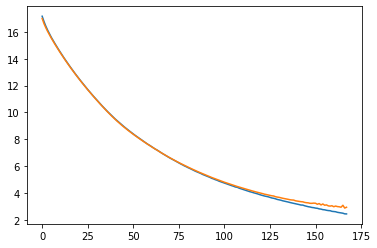

In [60]:
tf.debugging.set_log_device_placement(True)

X_train, X_val, y_train, y_val = train_test_split(train_with_miss, train_labels, test_size=0.1, random_state=13)


# model = lsst_model(input_shape = (6,36,1), num_classes = 14)
model = lsst_model(input_shape = (6,36,2), num_classes = 14)



loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay([1000, 2000], [1e-0, 1e-1, 1e-2])
lr = 1e-3 * schedule(step)
wd = lambda: 1e-4 * schedule(step)

    


# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# optimizer = AdamW(learning_rate=0.001, weight_decay = 10**(-4))
# optimizer = AdamW(learning_rate=lr, weight_decay=wd)
optimizer = tf.keras.optimizers.SGD(
    learning_rate=lr,
    momentum=0.8,
    nesterov=False
)


model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20, min_lr=0.0001)

loss_hist = model.fit(X_train, y_train, epochs=1000,
                       batch_size=32,
                       validation_data=(X_val, y_val),
                       callbacks=[reduce_lr,
                                  tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                mode='auto',
                                                verbose=0,
                                                patience=50,
                                                restore_best_weights=True)
                                  ]
                       )


import matplotlib.pyplot as plt

plt.plot(loss_hist.history['loss'])
plt.plot(loss_hist.history['val_loss'])


model.evaluate(test_with_miss,  test_labels, verbose=2)

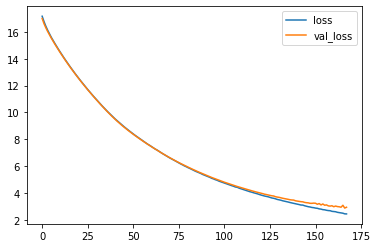

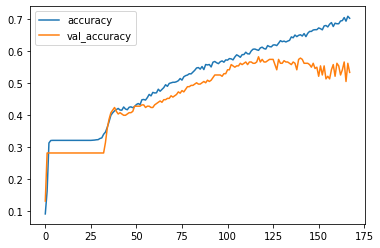

In [61]:

plt.plot(loss_hist.history['loss'], label = 'loss')
plt.plot(loss_hist.history['val_loss'], label  = 'val_loss')
# plt.ylim((0,5))
plt.legend()
plt.show()



plt.plot(loss_hist.history['accuracy'], label = 'accuracy')
plt.plot(loss_hist.history['val_accuracy'], label  = 'val_accuracy')
plt.legend()
plt.show()




In [63]:
model.save((PATH + 'model2'))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Thesis/LSST/model2/assets


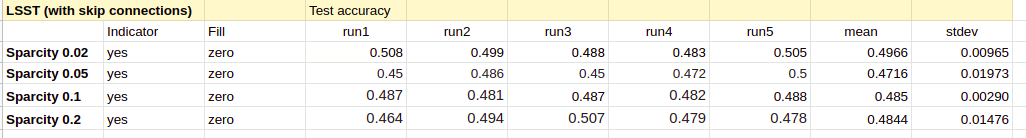